In [2]:
#import all the libraries

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [11]:
#data is in two categories: "mask" and "no mask"
#print total number o fimages in ecah category

print("The number of images labelled 'mask':",len(os.listdir('dataset/source/mask')))
print("The number of images labelled 'no_mask':",len(os.listdir('dataset/source/no_mask')))

The number of images labelled 'mask': 2606
The number of images labelled 'no_mask': 2616


In [6]:
#split_data function is defined to randomly split the source into train and test dataset
#each category is randomly split in the ratio 3:1

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    dataset = []  

    for unitData in os.listdir(SOURCE):

        data = SOURCE + unitData

        if(os.path.getsize(data) > 0):
            dataset.append(unitData)

        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')  

    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))

    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]     

    for unitData in train_set:

        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)  

    for unitData in test_set:

        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)

        #give path of source directory and train & test directory where images will be stores after splitting

WITHMASK_SOURCE_DIR = "dataset/source/mask/"
TRAINING_WITHMASK_DIR = "dataset/train/mask/"
TESTING_WITHMASK_DIR = "dataset/test/mask/"

WITHOUTMASK_SOURCE_DIR = "dataset/source/no_mask/"
TRAINING_WITHOUTMASK_DIR = "dataset/train/no_mask/"
TESTING_WITHOUTMASK_DIR = "dataset/test/no_mask/"

#specify the split size as 0.75:0.25
split_size = .75

split_data(WITHMASK_SOURCE_DIR, TRAINING_WITHMASK_DIR, TESTING_WITHMASK_DIR, split_size)
split_data(WITHOUTMASK_SOURCE_DIR, TRAINING_WITHOUTMASK_DIR, TESTING_WITHOUTMASK_DIR, split_size)

In [8]:
print("Total Images in each category: ")

print("Training: 'Mask': ", len(os.listdir('dataset/train/mask/')))

print("Testing: 'Mask': ", len(os.listdir('dataset/test/mask/')))

print("Training: 'No Mask': ", len(os.listdir('dataset/train/no_mask/')))

print("Testing: 'No Mask': ", len(os.listdir('dataset/test/no_mask/')))

Total Images in each category: 
Training: 'Mask':  1954
Testing: 'Mask':  652
Training: 'No Mask':  1962
Testing: 'No Mask':  654


In [12]:
#build a cnn model with two convolution layers

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


#compile the model using optimizer and give "accuracy" as the metric to measure
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [13]:
#use image data generator to augment data 

TRAINING_DIR = "dataset/train/"

#read training images from train directory and augment the data by using different parameters
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=64, 
                                                    target_size=(150, 150))

VALIDATION_DIR = "dataset/test/"

#read validation images from test directory and normalize the data
validation_datagen = ImageDataGenerator(rescale=1.0/255)

 
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                              batch_size=64, 
                                                              target_size=(150, 150))

#add callback and checkpoint

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 3916 images belonging to 2 classes.
Found 1306 images belonging to 2 classes.


In [14]:
#train the model for 30 epochs
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

#save the model
model.save('my_model_facemask.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 123 steps, validate for 41 steps
Epoch 1/30
 60/123 [=============>................] - ETA: 57s - loss: 0.6832 - acc: 0.6837

C:\Users\Ranjana\anaconda3\envs\tf-env\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


122/123 [============================>.] - ETA: 0s - loss: 0.5166 - acc: 0.7698WARNING:tensorflow:From C:\Users\Ranjana\anaconda3\envs\tf-env\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-001.model\assets
123/123 [==============================] - 124s 1s/step - loss: 0.5160 - acc: 0.7699 - val_loss: 0.1880 - val_acc: 0.9387
Epoch 2/30
123/123 [==============================] - 126s 1s/step - loss: 0.3657 - acc: 0.8475 - val_loss: 0.1920 - val_acc: 0.9326
Epoch 3/30
123/123 [==============================] - 129s 1s/step - loss: 0.3333 - acc: 0.8657 - val_loss: 0.1831 - val_acc: 0.9418
Epoch 4/30
123/123 [==============================] - 130s 1s/step - loss: 0.2916 - acc: 0.8810

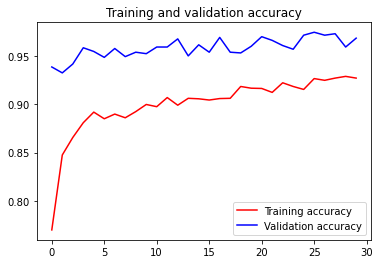

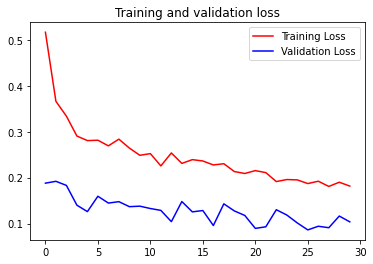

In [15]:
#plot the accuracy and loss graphs based on training

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
